<br>
<br>
<center>
<h1>Extracting Semi-Structured Data from PDFs on a large scale</h1>
</center>

FInancial data is often contained in semi-structured PDFs. While many tools exist for data extraction, not all are suitable in every case. Semi-structured hereby refers to the fact that PDFs, in contrast to html, regularly contain information in varying structure: Headlines may or may not exist; the number of pages often varies along with the size and position of characters. 

Using insights found on a blog [post](http://www.degeneratestate.org/posts/2016/Jun/15/extracting-tabular-data-from-pdfs/), the following pages will present what the contained data looks like and consider a more general solution for extracting data from PDFs.

For reading PDF files, I am using [PDFQuery](https://github.com/jcushman/pdfquery), while the extraction of the layout is done with the help of [pdfminer](https://github.com/euske/pdfminer). PDFQuery turned out to be a lot faster (~5 times) in reading the document, while pdfminer provides the necessary tools to extract the layouts. For the scale of a few thousand documents with multiple pages, a combination of the two was the best choice. 

The PDF layout we are dealing with comes in the form of a LTPage object. Each page in a PDF is described by a LTPage object and the hierarchical structure of lines, boxes, rectangles etc. which it contains. For the full hierarchy look [here](https://euske.github.io/pdfminer/programming.html#layout).

## Extract Layout and Characters
The following code - mainly taken from the blog-post mentioned above - will extract all LTPage objects from an example document. The contents of the document are anonymized.

In [1]:
from pdfquery import PDFQuery

from pdfminer.pdfpage import PDFPage, PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.layout import LAParams
from pdfminer.converter import PDFPageAggregator

from pathlib import Path
data_dir = Path('../data/')

In [2]:
def extract_page_layouts(file):
    """
    Extracts LTPage objects from a pdf file.
    modified from: http://www.degeneratestate.org/posts/2016/Jun/15/extracting-tabular-data-from-pdfs/
    Tests show that using PDFQuery to extract the document is ~ 5 times faster than pdfminer.
    """
    laparams = LAParams()
    
    with open(file, mode='rb') as pdf_file:
        print("Open document %s" % pdf_file.name)
        document = PDFQuery(pdf_file).doc

        if not document.is_extractable:
            raise PDFTextExtractionNotAllowed

        rsrcmgr = PDFResourceManager()
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        layouts = []
        for page in PDFPage.create_pages(document):
            interpreter.process_page(page)
            layouts.append(device.get_result())
    
    return layouts

example_file = data_dir / "example_anonymous.pdf"
page_layouts = extract_page_layouts(example_file)
print("Number of pages: %d" % len(page_layouts))

Open document ..\data\example_anonymous.pdf
Number of pages: 1


The page consists merely of lines/rectangles and text contained in the LTTextBox objects.

In [3]:
current_page = page_layouts[0]
for obj in set(type(o) for o in current_page):
    print(obj)

<class 'pdfminer.layout.LTRect'>
<class 'pdfminer.layout.LTTextBoxHorizontal'>


The following code separates the text from the other objects and shows the first three LTTextBoxes.

In [4]:
import pdfminer

texts = []
rects = []

# seperate text and rectangle elements
for elem in current_page:
    if isinstance(elem, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(elem)
    elif isinstance(elem, pdfminer.layout.LTRect):
        rects.append(elem)
texts[:3]

[<LTTextBoxHorizontal(0) 53.030,762.147,104.478,788.091 'Jane Doe\nFoo Bar Ltd.\n'>,
 <LTTextBoxHorizontal(1) 53.160,676.982,142.979,691.750 'Heading 1 is short\n'>,
 <LTTextBoxHorizontal(2) 92.640,637.577,146.067,650.321 'Segment 1-1\n'>]

We could already access the text in the LTTextBoxes, but we have no idea what the structure looks like yet. So let us break it down to each individual character and visualize the document's structure.

## Visualize the PDF structure

In [5]:
TEXT_ELEMENTS = [
    pdfminer.layout.LTTextBox,
    pdfminer.layout.LTTextBoxHorizontal,
    pdfminer.layout.LTTextLine,
    pdfminer.layout.LTTextLineHorizontal
]

def flatten(lst):
    """Flattens a list of lists"""
    return [item for sublist in lst for item in sublist]

def extract_characters(element):
    """
    Recursively extracts individual characters from 
    text elements. 
    """
    if isinstance(element, pdfminer.layout.LTChar):
        return [element]

    if any(isinstance(element, i) for i in TEXT_ELEMENTS):
        return flatten([extract_characters(e) for e in element])

    if isinstance(element, list):
        return flatten([extract_characters(l) for l in element])

    return []

In [6]:
# extract characters from texts
characters = extract_characters(texts)

Here comes the neat trick that Iain uses in his post to give an understanding of what the page looks like: He uses the bounding boxes describing each element in the PDF file and visualizes them.

In [7]:
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

def draw_rect_bbox(bbox, ax, color):
    """
    Draws an unfilled rectable onto ax.
    """
    x0,y0,x1,y1 = tuple(bbox)
    ax.add_patch( 
        patches.Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            fill=False,
            color=color
        )    
    )
    
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)

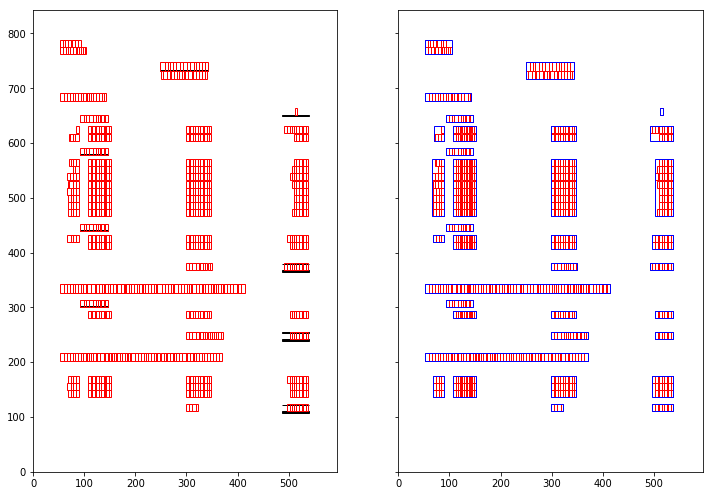

In [8]:
xmin, ymin, xmax, ymax = current_page.bbox
size = 6
num_pages = 2

fig, axes = plt.subplots(1,num_pages, figsize = (num_pages*size, size * (ymax/xmax)), sharey=True, sharex=True)

# rects and chars
ax = axes[0]
for rect in rects:
    draw_rect(rect, ax)
    
for c in characters:
    draw_rect(c, ax, "red")

# chars and TextBoxes
ax = axes[1]
for c in characters:
    draw_rect(c, ax, "red")    

for textbox in texts:
    draw_rect(textbox, ax, "blue")
    

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

On the left, I plotted all lines/rectangles and the bounding boxes of the characters. On the right, I plotted the bounding boxes of the characters and the TextBoxes. Here you can see why I talk about semi-structured data: the content of the pdf is arranged in rows and columns but there are no real separators to easily distinguish between the end of one logical entity and the beginning of another. The lines may indicate headlines but this conclusion does not seem to be consistent throughout the document. We have to find another approach in order to get this data into structure. Depending on the goal, there are several ways, each of them with its own advantages and disadvantages. By looking at the visualized document structure, I decided to approach this problem by also structuring the text row- and column-wise.

## Structuring the text data row-column-wise
We already extracted the LTChar objects. Now we arrange them row-wise and finally look at what we are doing this for: the text.

In [9]:
def arrange_text(characters):
    """
    For each row find the characters in the row
    and sort them horizontally.
    """
    
    # find unique y0 (rows) for character assignment
    rows = sorted(list(set(c.bbox[1] for c in characters)), reverse=True)
    
    sorted_rows = []
    for row in rows:
        sorted_row = sorted([c for c in characters if c.bbox[1] == row], key=lambda c: c.bbox[0])
        sorted_rows.append(sorted_row)
    return sorted_rows

sorted_rows = arrange_text(characters)

In [10]:
def extract_text(rows):
    row_texts = []
    for row in rows:
        row_text = ["".join([c.get_text() for c in row])]
        row_texts.append(row_text)
    return row_texts

row_texts = extract_text(sorted_rows)
row_texts[:18]

[['Jane Doe'],
 ['Foo Bar Ltd.'],
 ['Berechnung 2014'],
 ['(Calculation 2014)'],
 ['Heading 1 is short'],
 ['€'],
 ['Segment 1-1'],
 ['7PlatzhalterPlaceholder102.714,00'],
 ['/23BPlatzhalterPlaceholder505,00'],
 ['Segment 1-2'],
 ['/524PlatzhalterPlaceholder871,80'],
 ['3BPlatzhalterPlaceholder-103,34'],
 ['1AB9PlatzhalterPlaceholder1.234,83'],
 ['/XYZPlatzhalterPlaceholder-113,04'],
 ['D320PlatzhalterPlaceholder527,27'],
 ['0130PlatzhalterPlaceholder994,33'],
 ['8417PlatzhalterPlaceholder411,50'],
 ['X017PlatzhalterPlaceholder-602,50']]

This already looks readable. We appear to have some general information, a kind of identifier, descriptions in German and English and a monetary unit as well as an amount. However, this does not constitute clear data that one can put in a table or any other useful data-structure. What we need to do now is to separate the text column-wise. I wrote a little piece of code that creates a rectangle which fills the space between each column.

In [11]:
# define a margin that separates two columns
col_margin = 0.5

def create_separators(sorted_rows, margin):
    """Creates bounding boxes to fill the space between columns"""
    separators = []
    for row in sorted_rows:
        for idx, c in enumerate(row[:-1]): 
            if (row[idx+1].bbox[0] - c.bbox[2]) > margin:
                bbox = (c.bbox[2], c.bbox[3], row[idx+1].bbox[0], row[idx+1].bbox[1])
                separator = pdfminer.layout.LTRect(linewidth=2, bbox=bbox)
                separators.append(separator)
    return separators

separators = create_separators(sorted_rows, col_margin)

Visualize the separators to check how well the code works.

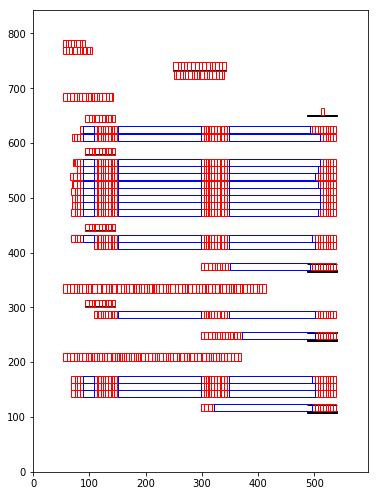

In [12]:
xmin, ymin, xmax, ymax = current_page.bbox
size = 6

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

# rects and chars
for rect in rects:
    draw_rect(rect, ax)
    
for c in characters:
    draw_rect(c, ax, "red")
    
for s in separators:
    draw_rect(s, ax, "blue")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

This works pretty well as a separator. Now I'm going to combine the logic of the **arrange_text()**, **extract_text()** and **create_separators()** functions to structure the text by row and column:

In [13]:
def arrange_and_extract_text(characters, margin=0.5):
    
    rows = sorted(list(set(c.bbox[1] for c in characters)), reverse=True)
    
    row_texts = []
    for row in rows:
        
        sorted_row = sorted([c for c in characters if c.bbox[1] == row], key=lambda c: c.bbox[0])
        
        col_idx=0
        row_text = []
        for idx, char in enumerate(sorted_row[:-1]):
            if (sorted_row[idx+1].bbox[0] - char.bbox[2]) > margin:
                col_text = "".join([c.get_text() for c in sorted_row[col_idx:idx+1]])
                col_idx = idx+1
                row_text.append(col_text)
            elif idx==len(sorted_row)-2:
                col_text = "".join([c.get_text() for c in sorted_row[col_idx:]])
                row_text.append(col_text) 
        row_texts.append(row_text)
    return row_texts

texts = arrange_and_extract_text(characters)
texts

[['Jane Doe'],
 ['Foo Bar Ltd.'],
 ['Berechnung 2014'],
 ['(Calculation 2014)'],
 ['Heading 1 is short'],
 [],
 ['Segment 1-1'],
 ['7', 'Platzhalter', 'Placeholder', '102.714,00'],
 ['/23B', 'Platzhalter', 'Placeholder', '505,00'],
 ['Segment 1-2'],
 ['/524', 'Platzhalter', 'Placeholder', '871,80'],
 ['3B', 'Platzhalter', 'Placeholder', '-103,34'],
 ['1AB9', 'Platzhalter', 'Placeholder', '1.234,83'],
 ['/XYZ', 'Platzhalter', 'Placeholder', '-113,04'],
 ['D320', 'Platzhalter', 'Placeholder', '527,27'],
 ['0130', 'Platzhalter', 'Placeholder', '994,33'],
 ['8417', 'Platzhalter', 'Placeholder', '411,50'],
 ['X017', 'Platzhalter', 'Placeholder', '-602,50'],
 ['Segment 1-3'],
 ['C311', 'Platzhalter', 'Placeholder', '41.384,00'],
 ['Platzhalter', 'Placeholder', '3.260,20'],
 ['Something:', '151.084,05'],
 ['Heading 2 which is actually very long, much longer than the first heading'],
 ['Segment 2-1'],
 ['Platzhalter', 'Placeholder', '1.127,40'],
 ['Something else:', '1.127,40'],
 ['Heading 3 i

Voila! Here you can see a neat row-column-structure. Note that rows containing only one character are empty. If you need those too, just add an if-statement to the **arrange_and_extract_text()** function. All you need to do now is to access the information you require. This is absolutely domain-dependent, so no generic solution exists. 

I hope you find this guide for extracting semi-structured text-data from pdf documents helpful. If you have any suggestions or remarks please send me an [email](mailto:captndata@gmail.com).

For those who are interested: In the following section I will give some examples and show a few ways of how the extracted data could be stored.

# Possible storing structures

## #1 Save the information in a pandas DataFrame object.
The visualization of the document shows that the lines which contain the numbers in our sheet are all 3 or 4 columns long. The easiest thing you can do is to check the length of each row and add the data to a dataframe if it matches the desired length. First, I am going to define the structure by assigning some meaningful names to the columns. Afterwards, I go through every row, check the length and add the text to the dataframe accordingly.

In [14]:
import pandas as pd
import numpy as np
columns = ['ID', 'ger_descr', 'eng_desc', 'amount']
df = pd.DataFrame(columns=columns)

In [15]:
for row in texts:
    if len(row) == 4:
        temp = pd.DataFrame([row], columns=columns)
        df = df.append(temp, ignore_index=True)
    elif len(row) == 3:
        row = row.copy()
        row.insert(0, np.nan)
        temp = pd.DataFrame([row], columns=columns)
        df = df.append(temp, ignore_index=True)
df

,ID,ger_descr,eng_desc,amount
0,7,Platzhalter,Placeholder,"102.714,00"
1,/23B,Platzhalter,Placeholder,"505,00"
2,/524,Platzhalter,Placeholder,"871,80"
3,3B,Platzhalter,Placeholder,"-103,34"
4,1AB9,Platzhalter,Placeholder,"1.234,83"
5,/XYZ,Platzhalter,Placeholder,"-113,04"
6,D320,Platzhalter,Placeholder,"527,27"
7,0130,Platzhalter,Placeholder,"994,33"
8,8417,Platzhalter,Placeholder,"411,50"
9,X017,Platzhalter,Placeholder,"-602,50"


## #2 Building a hierarchical dictionary to keep the structure
The first part of the document contains a name, company and the issue of this document together with a year indication. I store them in the dictionary, very straightforward.

In [16]:
data = {
    'General Info' : {
        'Name' : texts[0][0],
        'Company Name' : texts[1][0],
        'Issue' : texts[2][0][:-5],
        'Year' : texts[2][0][-4:]
    }
}
data['General Info']

{'Name': 'Jane Doe',
 'Company Name': 'Foo Bar Ltd.',
 'Issue': 'Berechnung',
 'Year': '2014'}

The rest of the document is divided in a kind of hierarchie: three bigger paragraphs, each of ending with some kind of sum, indicated by the over- and underlines. Each of the paragraphs has a headline for which we define labels. The first paragraph is further divided into segments for which I will define sublabels. We can easily check if the row we are processing is a label, sublabel or sum and process the rest of the text accordingly.

In [17]:
LABELS =[
    'Heading 1 is short',
    'Heading 2 which is actually very long, much longer than the first heading',
    'Heading 3 is also a little bit longer but not as long as the second'
]

SUBLABELS = [
    'Segment 1-1',
    'Segment 1-2',
    'Segment 1-3',
    'Segment 2-1'
]

SUMS = [
    'Something:',
    'Something else:',
    'Sum:'
]

In [18]:
key = None
subkey = None
for row in texts[4:]:
    # assure that row isn't empty
    if row:
        word = row[0]
    else:
        continue
    
    if word in LABELS:
        key = word
        subkey = None
        data[key] = {}
    elif word in SUBLABELS:
        subkey = word
        data[key][subkey] = {}
    elif word in SUMS:
        data[key]['Sum'] = row[-1]
    elif subkey:
        ID = " ".join(row[:-1])
        data[key][subkey][ID] = row[-1]
    elif key:
        ID = " ".join(row[:-1])
        data[key][ID] = row[-1]

With the dictionary one can easily access the desired data and still take the hierarchical information into account:

In [19]:
for label in data.keys():
    print("*"*3, label, "*"*3)
    for k,v in data[label].items():
        print(k)
        print(v, "\n")

*** General Info ***
Name
Jane Doe 

Company Name
Foo Bar Ltd. 

Issue
Berechnung 

Year
2014 

*** Heading 1 is short ***
Segment 1-1
{'7 Platzhalter Placeholder': '102.714,00', '/23B Platzhalter Placeholder': '505,00'} 

Segment 1-2
{'/524 Platzhalter Placeholder': '871,80', '3B Platzhalter Placeholder': '-103,34', '1AB9 Platzhalter Placeholder': '1.234,83', '/XYZ Platzhalter Placeholder': '-113,04', 'D320 Platzhalter Placeholder': '527,27', '0130 Platzhalter Placeholder': '994,33', '8417 Platzhalter Placeholder': '411,50', 'X017 Platzhalter Placeholder': '-602,50'} 

Segment 1-3
{'C311 Platzhalter Placeholder': '41.384,00', 'Platzhalter Placeholder': '3.260,20'} 

Sum
151.084,05 

*** Heading 2 which is actually very long, much longer than the first heading ***
Segment 2-1
{'Platzhalter Placeholder': '1.127,40'} 

Sum
1.127,40 

*** Heading 3 is also a little bit longer but not as long as the second ***
A027 Platzhalter Placeholder
40.116,93 

C039 Platzhalter Placeholder
4.331,35 
